# **World Happiness Index Modeling**

<img src="whr-cover-ico.png" alt="WHI" width="300"/>


**World Happiness Index** is a comprehensive indicator that measures the level of perceived happiness in various countries. It was developed by the Sustainable Development Solutions Network (SDSN), a network for sustainable development solutions operating under the aegis of the United Nations (UN). The data for the index is derived from extensive surveys where respondents rate their lives on a scale from 0 to 10, with 0 indicating the worst possible quality of life and 10 the best.

The ranking is published annually, and the results are used not only to assess the progress of countries towards sustainable development goals but also serve as a tool for policymakers to develop and modify policies aimed at enhancing the overall level of happiness and quality of life.

This index serves as an important diagnostic tool that helps understand how different policies and socio-economic conditions affect the well-being of citizens, thereby contributing to promoting global initiatives aimed at building more harmonious and happier societies.

### **Links to data (the official report website):**
- [Official WHI_2023 Report](https://worldhappiness.report/data/)

### 1. **Importing Libraries**

At the beginning, the necessary libraries were imported:

- **numpy, pandas** - for data manipulation,,
- **seaborn**, **matplotlib**, **plotly** -  for data visualization,
- **pathlib** - for creating file paths,
- **sklearn** - for predictive modeling (linear regression, polynomial regression, random forest, and AdaBoost).

In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeRegressor

### 2. **Loading Data**

The data was loaded from a CSV file containing panel data.

In [172]:
# Paths
csv_path = Path() / "csv"
plots_path = Path() / "plots"

df = pd.read_csv(csv_path / 'WHI.csv')

# Shape of the DataFrame (number of rows, number of columns) before processing
print(df.shape)

df.head()

(2363, 11)


,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


### 3. **Pre-processing danych**

*Pre-processing* involved the *a priori* selection of analyzed variables, renaming columns, removing rows with incomplete data, resetting the index, verifying data type correctness, and ensuring there are no duplicates in the data.

#### **Description of Data Columns Used in Further Analysis**:
- **Country** (Country name): Name of the country,
- **Score** (Life ladder): Subjective happiness level of the residents of a given country (survey on a scale from 0 to 10),
- **GDP per capita** (Logged GDP per capita): Logarithm of gross domestic product per capita, expressed in dollars,
- **Social support**: Social support index, referring to the quality and availability of support from family, friends, and others in society (survey on a scale from 0 to 1),
- **Life expectancy** (Healthy life expectancy at birth): Estimated number of years of healthy life at birth,
- **Freedom** (Freedom to make life choices): Level of personal freedom, meaning the ability to make life choices without external constraints (survey on a scale from 0 to 1),
- **Generosity**: Average level of generosity in the country, measured as the difference between the share of people declaring help to others and those who do not,
- **Perceptions of corruption**: Perception of corruption in the country, i.e., how widespread corrupt practices are according to residents (survey on a scale from 0 to 1).

In [173]:
# Data types inside columns and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [174]:
# Selection of columns for further analysis
df = df[[
    'Country name',
    'year',
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption'
]].reset_index(drop=True)

# Renaming selected columns
df = df.rename(columns={
    'Country name':'Country',
    'Life Ladder': 'Score',
    'Log GDP per capita': 'GDP per capita',
    'Healthy life expectancy at birth': 'Life expectancy',
    'Freedom to make life choices': 'Freedom',
    'Perceptions of corruption': 'Corruption'
})

df.head()

,Country,year,Score,GDP per capita,Social support,Life expectancy,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776


In [175]:
# Checking for ‘NaN’ - empty cells in columns
print(df.isnull().sum())

# Counting the number of rows with missing values
num_rows_with_nan = df[df.isnull().any(axis=1)].shape[0]
print(f'Number of rows with at least one NaN value: {num_rows_with_nan}.')

Country              0
year                 0
Score                0
GDP per capita      28
Social support      13
Life expectancy     63
Freedom             36
Generosity          81
Corruption         125
dtype: int64
Number of rows with at least one NaN value: 260.


In [176]:
# Removing rows with at least one NaN value
df = df.dropna()

In [177]:
# Checking for duplicates in the data
duplicates_num = df.duplicated().sum()

if duplicates_num == 0:
    print('There are no duplicates in the data.')
else:
    print('There are', duplicates_num, 'duplicates.')

There are no duplicates in the data.


In [178]:
# Shape of the DataFrame (number of rows, number of columns) after processing
print(df.shape)

# Data types inside columns
df.info()

# Displaying descriptive statistics for selected columns
selected_columns = ['Score', 'GDP per capita', 'Social support', 'Life expectancy', 'Freedom', 'Generosity', 'Corruption']
df[selected_columns].describe().T

(2103, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 2103 entries, 0 to 2362
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          2103 non-null   object 
 1   year             2103 non-null   int64  
 2   Score            2103 non-null   float64
 3   GDP per capita   2103 non-null   float64
 4   Social support   2103 non-null   float64
 5   Life expectancy  2103 non-null   float64
 6   Freedom          2103 non-null   float64
 7   Generosity       2103 non-null   float64
 8   Corruption       2103 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 164.3+ KB


,count,mean,std,min,25%,50%,75%,max
Score,2103.0,5.465162,1.135956,2.179,4.612,5.432,6.2885,7.971
GDP per capita,2103.0,9.354218,1.154002,5.527,8.465,9.496,10.3140,11.676
Social support,2103.0,0.806939,0.123662,0.290,0.736,0.834,0.9050,0.987
Life expectancy,2103.0,63.268982,6.995093,6.720,58.660,65.075,68.6775,74.600
Freedom,2103.0,0.748899,0.138700,0.258,0.659,0.769,0.8595,0.985
Generosity,2103.0,0.000141,0.162105,-0.340,-0.110,-0.021,0.0925,0.700
Corruption,2103.0,0.747160,0.183664,0.035,0.691,0.800,0.8680,0.983


- **Distribution of features**:

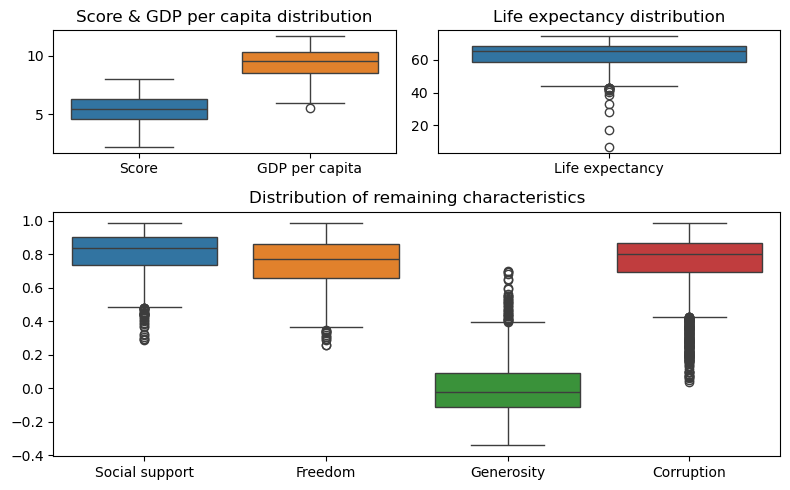

In [179]:
# Creating the figure and grid
fig = plt.figure(figsize=(8, 5))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

# Distribution of ‘Score’ and ‘GDP per capita’
ax1 = fig.add_subplot(gs[0, 0])
list_features_1 = ['Score', 'GDP per capita']
sns.boxplot(data=df[list_features_1], ax=ax1)
ax1.set_title('Score & GDP per capita distribution')

# Distribution of 'Life expectancy'
ax2 = fig.add_subplot(gs[0, 1])
list_features_2 = ['Life expectancy']
sns.boxplot(data=df[list_features_2], ax=ax2)
ax2.set_title('Life expectancy distribution')

# Distribution of remaining characteristics
ax3 = fig.add_subplot(gs[1, :])
rest_list_features = ['Social support', 'Freedom', 'Generosity', 'Corruption']
sns.boxplot(data=df[rest_list_features], ax=ax3)
ax3.set_title('Distribution of remaining characteristics')

plt.tight_layout()
plt.savefig(plots_path / 'distribution.svg')
plt.show()

Based on the analysis of the WHI data, it can be concluded that the global perception of quality of life is moderately positive, with an average happiness score of 5.465. The range of scores from 2.179 to 7.971 indicates significant variation in happiness levels across different countries. Similar conclusions can be drawn for the other variables.

The average value of social support is 0.807, suggesting that strong support networks exist in many parts of the world. Life expectancy has an average value of 63.27 years, with the highest value being 74.6 years, highlighting disparities in access to healthcare. The average personal freedom is 0.749, which may indicate a generally high level of personal freedom in the analyzed countries. The average generosity close to zero with a wide range of variability shows that generosity is perceived and practiced differently in various societies. The perception of corruption has an average of 0.747, suggesting that corruption is highly visible to the public in many regions.

- **Histograms and bar charts depicting the relationships between subsequent columns**:

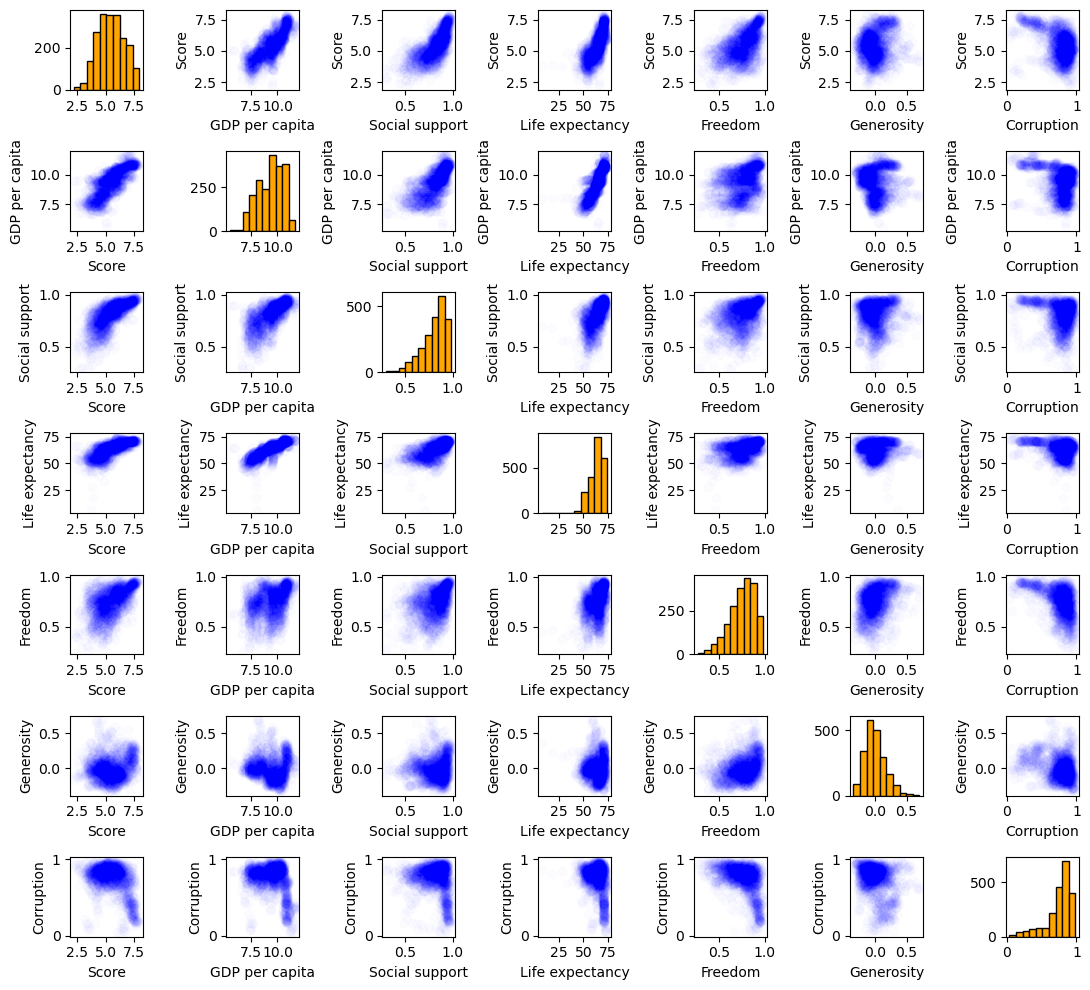

In [180]:
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(11, 10))

for i, column1 in enumerate(selected_columns):
    for j, column2 in enumerate(selected_columns):
        if i == j:
            axes[i, j].hist(df[column1], bins=10, color='orange', edgecolor='black')
        else:
            axes[i, j].scatter(df[column2], df[column1], color='blue', alpha=0.01)
            axes[i, j].set_xlabel(column2)
            axes[i, j].set_ylabel(column1)

plt.tight_layout()
plt.savefig(plots_path / 'dependencies_characteristics.svg')
plt.show()

- **Correlation**:

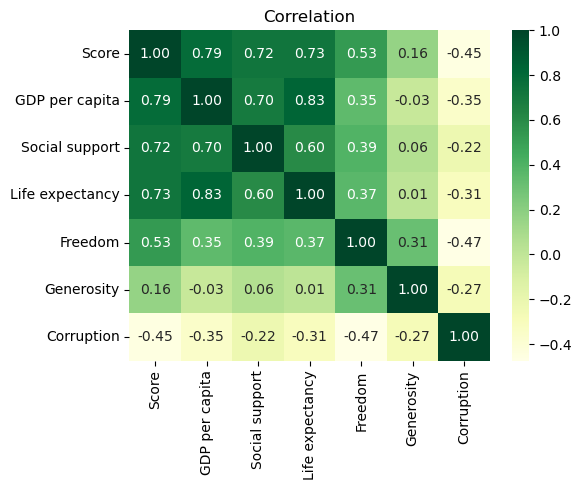

In [181]:
# Removing unnecessary columns for heatmap
df_corr = df[selected_columns]
corr_matrix = df_corr.corr()

# Heatmap settings
plt.figure(figsize=(6, 5))
plt.title("Correlation")
sns.heatmap(corr_matrix, cmap='YlGn', annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(plots_path / 'correlation.svg')
plt.show()

- A high score correlates positively with high GDP per capita, social support, life expectancy, and freedom, and negatively with corruption.
- GDP per capita is strongly associated with GDP, life expectancy, and social support, suggesting that a higher economic level promotes better living conditions. Freedom and social support are also important for well-being, although to a lesser extent than the other factors.
- Corruption negatively impacts all major indicators, emphasizing the importance of transparency and the rule of law for societal well-being.

### 4. **Visualizations helpful in understanding the data**

#### **WHI in 2023**:

In [182]:
# Extracting data for the year 2023
df_2023 = df[df['year'] == 2023]

# Sorting data by highest ‘Life Ladder’ scores
df_2023 = df_2023.sort_values(by='Score', ascending=False)

# Resetting the index
df_2023 = df_2023.reset_index(drop=True)

# Displaying the first few rows of the DataFrame
df_2023.head()

,Country,year,Score,GDP per capita,Social support,Life expectancy,Freedom,Generosity,Corruption
0,Finland,2023,7.699,10.808,0.947,71.3,0.943,-0.001,0.185
1,Iceland,2023,7.562,10.934,0.979,72.1,0.918,0.299,0.697
2,Denmark,2023,7.504,10.996,0.916,71.5,0.923,0.089,0.184
3,Costa Rica,2023,7.384,10.021,0.875,70.0,0.933,-0.067,0.767
4,Netherlands,2023,7.255,10.977,0.915,71.7,0.847,0.223,0.424


- **Bar chart presenting all analyzed countries in 2023**:

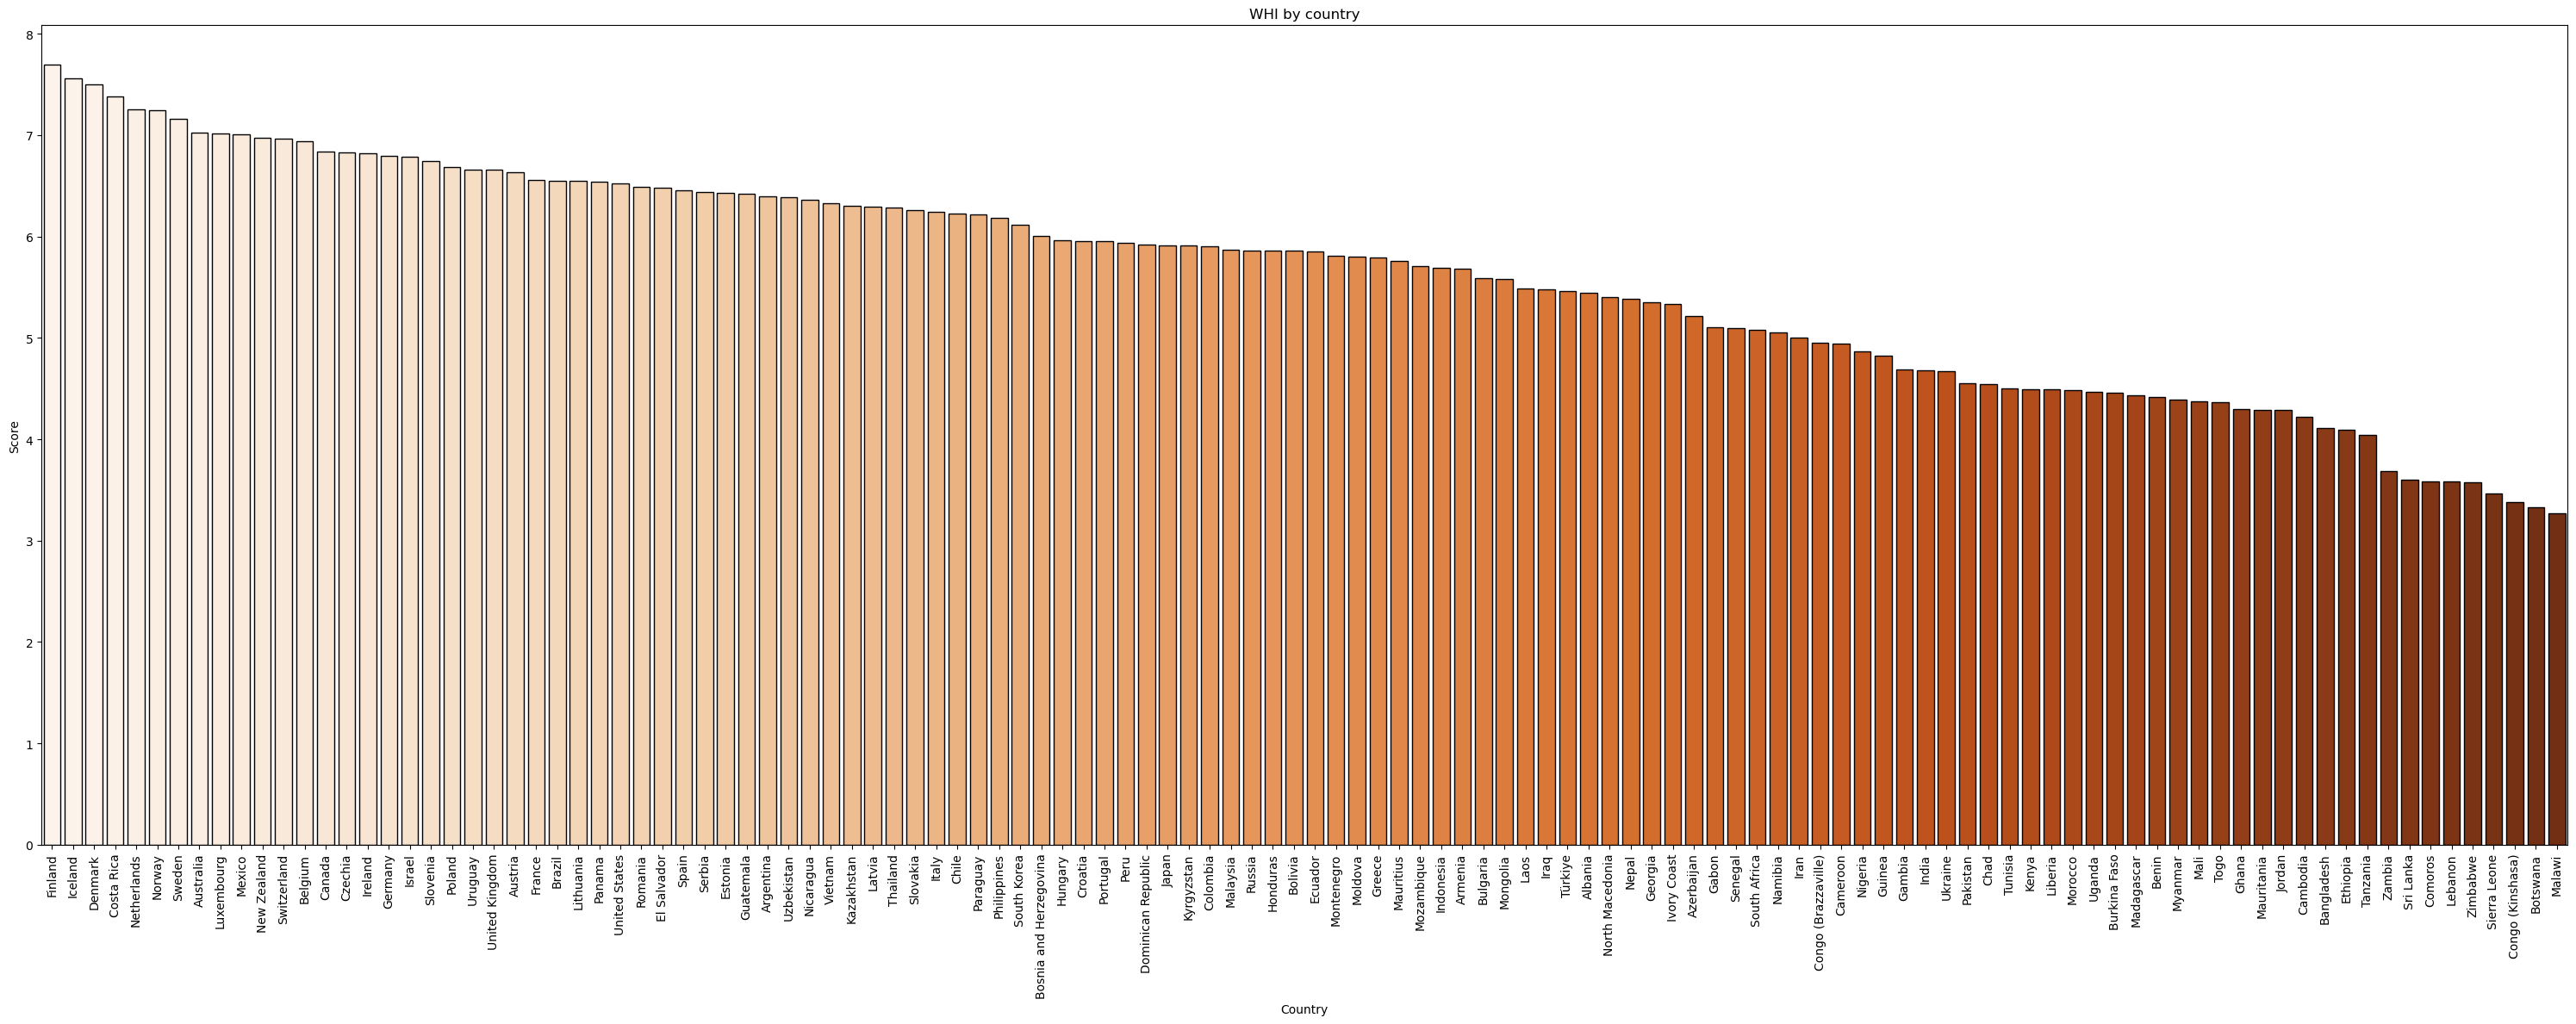

In [183]:
plt.figure(figsize=(30,12))
sns.barplot(x='Country', y='Score', data=df_2023, hue='Country', palette='Oranges', edgecolor='black', legend=False)
plt.xticks(rotation=90)
plt.title('WHI by country')
plt.tight_layout()
plt.savefig(plots_path / 'whi_all_countries.svg')
plt.show()

- **Chart showing the happiest and least happy countries in 2023**:

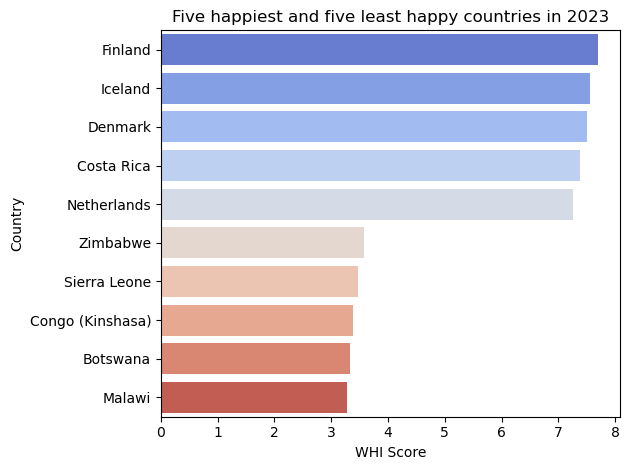

In [184]:
df_2023_max_min = df_2023[(df_2023.loc[:, "Score"] > 7.25) | (df_2023.loc[:, "Score"] < 3.58)]
sns.barplot(x = "Score", y = "Country", hue="Country", data=df_2023_max_min, palette = "coolwarm", legend=False)
plt.title("Five happiest and five least happy countries in 2023")
plt.xlabel('WHI Score')
plt.ylabel('Country')
plt.tight_layout()
plt.savefig(plots_path / 'whi_highest_lowest.svg')
plt.show()

#### **Data from all survey years**:

- **Data for Poland over the years**:

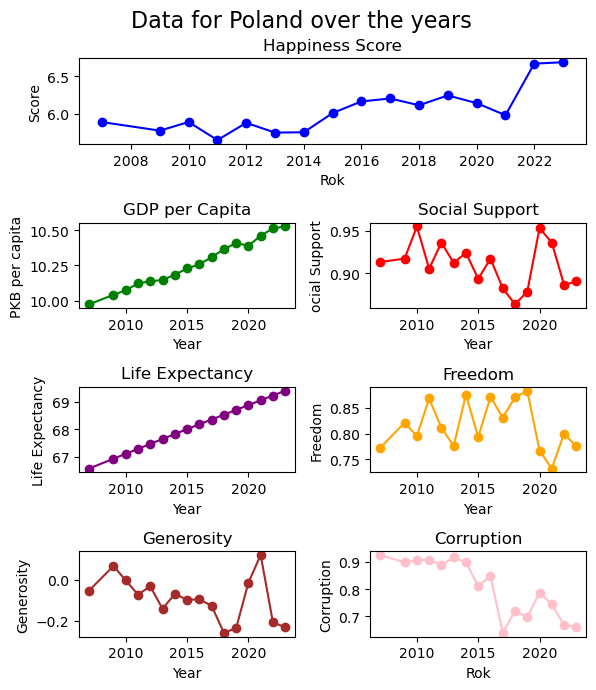

In [185]:
poland = df[df['Country']=='Poland'].reset_index(drop=True)

fig = plt.figure(figsize=(6, 7))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2, rowspan=1)
ax1.plot(poland['year'], poland['Score'], marker='o', color='blue')
ax1.set_title('Happiness Score')
ax1.set_xlabel('Rok')
ax1.set_ylabel('Score')

ax2 = plt.subplot2grid((4, 2), (1, 0))
ax2.plot(poland['year'], poland['GDP per capita'], marker='o', color='green')
ax2.set_title('GDP per Capita')
ax2.set_xlabel('Year')
ax2.set_ylabel('PKB per capita')

ax3 = plt.subplot2grid((4, 2), (1, 1))
ax3.plot(poland['year'], poland['Social support'], marker='o', color='red')
ax3.set_title('Social Support')
ax3.set_xlabel('Year')
ax3.set_ylabel('ocial Support')

ax4 = plt.subplot2grid((4, 2), (2, 0))
ax4.plot(poland['year'], poland['Life expectancy'], marker='o', color='purple')
ax4.set_title('Life Expectancy')
ax4.set_xlabel('Year')
ax4.set_ylabel('Life Expectancy')

ax5 = plt.subplot2grid((4, 2), (2, 1))
ax5.plot(poland['year'], poland['Freedom'], marker='o', color='orange')
ax5.set_title('Freedom')
ax5.set_xlabel('Year')
ax5.set_ylabel('Freedom')

ax6 = plt.subplot2grid((4, 2), (3, 0))
ax6.plot(poland['year'], poland['Generosity'], marker='o', color='brown')
ax6.set_title('Generosity')
ax6.set_xlabel('Year')
ax6.set_ylabel('Generosity')

ax7 = plt.subplot2grid((4, 2), (3, 1))
ax7.plot(poland['year'], poland['Corruption'], marker='o', color='pink')
ax7.set_title('Corruption')
ax7.set_xlabel('Rok')
ax7.set_ylabel('Corruption')

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Data for Poland over the years', fontsize=16)
plt.savefig(plots_path / 'poland_data.svg')
plt.show()

During the analyzed period, Poland experienced an overall improvement in many key indicators such as GDP per capita, life expectancy, and happiness index. While social support and personal freedom remained relatively stable, generosity and perceptions of corruption showed greater fluctuations. Overall, these results suggest that living conditions in Poland are gradually improving, although certain areas require further attention.

- **Interactive Map**:

In [186]:
# Adding a column with all ‘Score’ values along with the year
df['Year_Score'] = df['year'].astype(str) + ': ' + df['Score'].astype(str)

# Sorting the scores from newest to oldest before merging
df['All Scores'] = df.groupby('Country')['Year_Score'].transform(lambda x: '<br>'.join(sorted(x, reverse=True)))

# Sorting the data by year in descending order
df_sorted = df.sort_values(by='year', ascending=False)

# Removing duplicates to keep only the latest results for each country
df_latest = df_sorted.drop_duplicates(subset=['Country'])

# Map colours
custom_color_scale = [(0.0, 'red'), 
                      (0.5, 'yellow'), 
                      (1.0, 'green')
                      ]

# Data for the map using the DataFrame with the latest results
fig = px.choropleth(df_latest, locations='Country', 
                    locationmode='country names',
                    color='Score', 
                    hover_name='Country',
                    hover_data={'All Scores': True},
                    color_continuous_scale=custom_color_scale
                    )

# Setting the title and centering it
fig.update_layout(title_text='World Happiness Index', title_x=0.5)
fig.show()

### 5. **Predictive Modeling**

Four regression models were implemented:

- Multiple Regression,
- Polynomial Regression,
- Random Forest,
- AdaBoost.

Each of the above models was tested for mean squared error (MSE) and the coefficient of determination (R2). To do this, the variables were first split into the dependent variable Y, which was the happiness score, and the independent variables X (all other variables). The data was then divided into training and testing sets.

In [187]:
# Definition of features and target variable
features = ['GDP per capita', 'Social support', 'Life expectancy', 
            'Freedom', 'Generosity', 'Corruption']
target = 'Score'

# Data Preparation
X = df[features]
Y = df[target]

In [188]:
# Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [189]:
# Function to create plots of actual data vs. model predictions
def plot_actual_vs_predicted(ax, y_true, y_pred, model_name, mse, r2, color):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, label='Model Prediction')
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Actual Data')
    ax.set_ylabel('Model Predictions')
    ax.legend()
    mse_text = f'MSE: {mse:.2f}'
    r2_text = f'R^2: {r2:.2f}'
    ax.text(0.86, 0.05, mse_text, transform=ax.transAxes, verticalalignment='top', fontsize=9, color=color)
    ax.text(0.86, 0.10, r2_text, transform=ax.transAxes, verticalalignment='top', fontsize=9, color=color)

#### **MODEL 1: Multiple Linear Regression**

Multiple linear regression is a statistical technique that models the relationship between one dependent variable and two or more independent variables. It allows for the assessment of how different independent variables contribute to the dependent variable. This technique is used when we want to understand the impact of several different factors on an outcome and to find patterns in the data.

The model utilized cross-validation to ensure an objective evaluation and better generalization by using each available data sample for both training and testing the model. This minimizes the risk of overfitting and increases the reliability of the results.

In [190]:
# Multiple Linear Regression

# Initialization of the model and training on the training data
mlr_model = LinearRegression()
mlr_model.fit(X_train, Y_train)

# Cross-Validation
cv_linear = cross_val_score(estimator = mlr_model, X = X_train, y = Y_train, cv = 10)
std_cv_score = np.std(cv_linear)

Y_train_pred_mlr = mlr_model.predict(X_train)
Y_test_pred_mlr = mlr_model.predict(X_test)

# Calculating model fit to the data
residuals_mlr = Y_test - Y_test_pred_mlr
mlr_train_mse = mean_squared_error(Y_train, Y_train_pred_mlr)
mlr_test_mse = mean_squared_error(Y_test, Y_test_pred_mlr)
mlr_train_r2 = r2_score(Y_train, Y_train_pred_mlr)
mlr_test_r2 = r2_score(Y_test, Y_test_pred_mlr)

print("CV results: ", cv_linear)
print("Mean CV value: ", cv_linear.mean())
print("Std of CV values:", std_cv_score)

CV results:  [0.67486123 0.70012399 0.79196007 0.72598963 0.78170096 0.76219964
 0.75171184 0.76505392 0.76413341 0.75527564]
Mean CV value:  0.7473010329093024
Std of CV values: 0.03465352796444072


#### **MODEL 2: Polynomial Regression**

Polynomial regression is an extension of linear regression that allows for modeling nonlinear relationships by raising the independent variables to higher powers. It is useful when the relationships between the dependent variable and the independent variables appear more complex than a simple line.

A third-degree polynomial generated better results than a second-degree polynomial, hence its selection for further analysis.

In [191]:
# Polynomial Regression

# Creating a PolynomialFeatures object to generate Polynomial Features
poly = PolynomialFeatures(degree=3, include_bias=False)

# Transforming input features into Polynomial Features
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(X_poly, Y, test_size=0.2, random_state=42)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train_poly)

# Cross-Validation
cv_poly = cross_val_score(estimator=poly_model, X=X_train_poly, y=Y_train_poly, cv=10)
std_cv_poly = np.std(cv_poly)

Y_train_pred_poly = poly_model.predict(X_train_poly)
Y_test_pred_poly = poly_model.predict(X_test_poly)
poly_train_mse = mean_squared_error(Y_train_poly, Y_train_pred_poly)
poly_test_mse = mean_squared_error(Y_test_poly, Y_test_pred_poly)
poly_train_r2 = r2_score(Y_train_poly, Y_train_pred_poly)
poly_test_r2 = r2_score(Y_test_poly, Y_test_pred_poly)

print("CV results: ", cv_poly)
print("Mean CV value: ", cv_poly.mean())
print("Std of CV values:", std_cv_poly)

CV results:  [0.7128189  0.76356289 0.7991967  0.77083134 0.80062102 0.80384601
 0.61957922 0.74467442 0.7758161  0.76740281]
Mean CV value:  0.7558349406261181
Std of CV values: 0.052487456854396555


#### **MODEL 3: Random Forest**

Random forest is a machine learning method based on aggregating multiple decision trees to predict an outcome. Each tree is trained on slightly different samples of data, making the model more robust to overfitting and better at generalizing to new data compared to a single decision tree.

In [192]:
# Feature Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature normalization was performed using the StandardScaler from the scikit-learn library. Normalization transforms the data to have a mean value of 0 and a standard deviation of 1. This is an important step to ensure that all features have a comparable range of values, which helps improve the efficiency of machine learning models.

In [193]:
# Defining a grid of hyperparameters (more restrictive values)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 6, 8],
    'bootstrap': [True]
}

The hyperparameter grid was defined to find the best parameters for the RandomForestRegressor model. The ranges of values for various parameters, such as the number of trees in the forest (n_estimators), the maximum number of features to consider for each split (max_features), the maximum depth of the tree (max_depth), the minimum number of samples required to split an internal node (min_samples_split), and the minimum number of samples required to be at a leaf node (min_samples_leaf), were specified.

In [194]:
# Model initialization
rf_model = RandomForestRegressor(random_state=42)

The RandomForestRegressor model is initialized with the random_state parameter set to ensure the reproducibility of results.

In [195]:
# Tuning Hyperparameters using GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 200, 300]})

GridSearchCV is used to search for the best hyperparameters. The search is performed by trying all combinations defined in the param_grid, using 10-fold cross-validation (cv=10). The parameter n_jobs=-1 means that all available processors will be used for computations, and verbose=2 sets the level of detail of the output.

In [196]:
# Best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Initializing the model with the best hyperparameters
rf_model_best = RandomForestRegressor(**best_params, random_state=42)
rf_model_best.fit(X_train_scaled, Y_train)

# Predictions
Y_train_pred_rf = rf_model_best.predict(X_train_scaled)
Y_test_pred_rf = rf_model_best.predict(X_test_scaled)

# Model evaluation​
rf_train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
rf_test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
rf_train_r2 = r2_score(Y_train, Y_train_pred_rf)
rf_test_r2 = r2_score(Y_test, Y_test_pred_rf)

Best Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [197]:
# Cross-Validation results from GridSearchCV
cv_results_rf = grid_search.cv_results_

# Creating a DataFrame with results
cv_results_df_rf = pd.DataFrame(cv_results_rf)

# Displaying the most important columns
cv_results_summary_rf = cv_results_df_rf[['mean_test_score', 'std_test_score']].sort_values(by='mean_test_score')
print('Mean CV values:\n', cv_results_summary_rf.mean())

Mean CV values:
 mean_test_score    0.811321
std_test_score     0.026753
dtype: float64


#### **MODEL 4: Adaptive Boosting (AdaBoost)**

Adaptive Boosting, also known as AdaBoost, is one of the pioneering boosting techniques in the field of machine learning, aimed at enhancing model performance by sequentially training a series of so-called weak classifiers. Each subsequent classifier in the series is constructed to correct the errors made by its predecessors, leading to a gradual strengthening of the overall predictive power of the model.

In [198]:
# Defining the Base Estimator
base_estimator = DecisionTreeRegressor()

# Defining the AdaBoost Model
ada_boost_model = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Defining the Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [2, 4, 6]
}

# Searching the Hyperparameter Grid using GridSearchCV
grid_search = GridSearchCV(estimator=ada_boost_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Training the model with GridSearchCV
grid_search.fit(X_train, Y_train)

# Obtaining the best model
best_model = grid_search.best_estimator_

# Predictions using the best model
Y_train_pred_ada = best_model.predict(X_train)
Y_test_pred_ada = best_model.predict(X_test)

# Evaluation of the best model
ada_train_mse = mean_squared_error(Y_train, Y_train_pred_ada)
ada_test_mse = mean_squared_error(Y_test, Y_test_pred_ada)
ada_train_r2 = r2_score(Y_train, Y_train_pred_ada)
ada_test_r2 = r2_score(Y_test, Y_test_pred_ada)

# Displaying the results
print("The best parameters:", grid_search.best_params_)

The best parameters: {'estimator__max_depth': 6, 'learning_rate': 1, 'n_estimators': 200}


In [199]:
# Cross-Validation results from GridSearchCV
cv_results_ada = grid_search.cv_results_

# Creating a DataFrame with results
cv_results_df_ada = pd.DataFrame(cv_results_ada)

# Displaying the most important columns
cv_results_summary_ada = cv_results_df_ada[['mean_test_score', 'std_test_score']].sort_values(by='mean_test_score')
print('Mean CV values:\n', cv_results_summary_ada.mean())

Mean CV values:
 mean_test_score    0.768256
std_test_score     0.027073
dtype: float64


### 6. **Results of All Used Models**
- **Charts of Model Fit to Actual Data**:

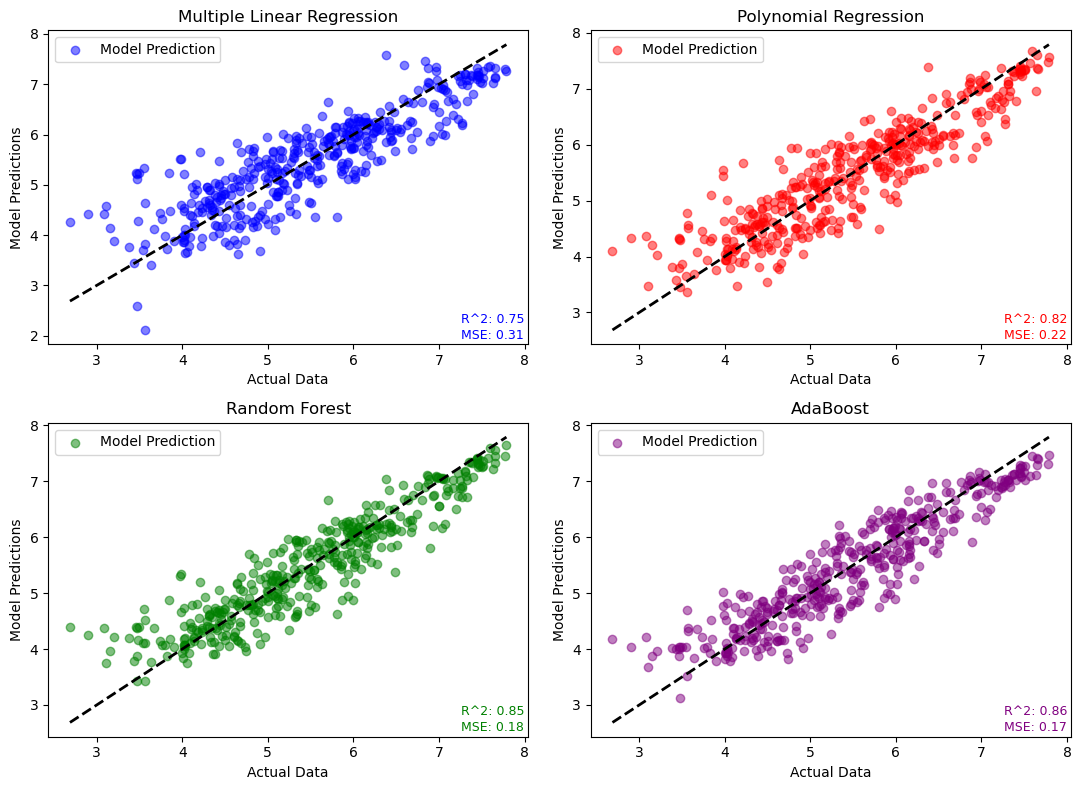

In [200]:
# Create a 2x2 grid for plots
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# Plot each model in the grid
plot_actual_vs_predicted(axes[0, 0], Y_test, Y_test_pred_mlr, 'Multiple Linear Regression', mlr_test_mse, mlr_test_r2, 'blue')
plot_actual_vs_predicted(axes[0, 1], Y_test_poly, Y_test_pred_poly, 'Polynomial Regression', poly_test_mse, poly_test_r2, 'red')
plot_actual_vs_predicted(axes[1, 0], Y_test, Y_test_pred_rf, 'Random Forest', rf_test_mse, rf_test_r2, 'green')
plot_actual_vs_predicted(axes[1, 1], Y_test, Y_test_pred_ada, 'AdaBoost', ada_test_mse, ada_test_r2, 'purple')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(plots_path / 'all_models_comparison.svg')
plt.show()

- **Table containing all obtained results**:

In [201]:
# List with all results
data = {
    "Model": ["Multiple Linear Regression", "Polynomial Regression", "Random Forest", "AdaBoost"],
    "Training MSE": [mlr_train_mse, poly_train_mse, rf_train_mse, ada_train_mse],
    "Test MSE": [mlr_test_mse, poly_test_mse, rf_test_mse, ada_test_mse],
    "Training R2": [mlr_train_r2, poly_train_r2, rf_train_r2, ada_train_r2],
    "Test R2": [mlr_test_r2, poly_test_r2, rf_test_r2, ada_test_r2]
}

results = pd.DataFrame(data)

results

,Model,Training MSE,Test MSE,Training R2,Test R2
0,Multiple Linear Regression,0.321784,0.305350,0.753924,0.749375
1,Polynomial Regression,0.248776,0.222160,0.809755,0.817655
2,Random Forest,0.105150,0.178880,0.919589,0.853179
3,AdaBoost,0.109352,0.174123,0.916376,0.857083


- **Learning curves for all models**:

In [202]:
# Calculate learning curves for each model
train_sizes_mr, train_scores_mr, test_scores_mr = learning_curve(mlr_model, X_train, Y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
train_sizes_poly, train_scores_poly, test_scores_poly = learning_curve(poly_model, X_train_poly, Y_train_poly, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf_model_best, X_train_scaled, Y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
train_sizes_ada, train_scores_ada, test_scores_ada = learning_curve(best_model, X_train_scaled, Y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

In [203]:
# Mean and standard deviation of scores
# Define a function to calculate mean and std
def calculate_mean_std(train_scores, test_scores):
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

# Calculate mean and std for each model
train_scores_mean_mr, train_scores_std_mr, test_scores_mean_mr, test_scores_std_mr = calculate_mean_std(train_scores_mr, test_scores_mr)
train_scores_mean_poly, train_scores_std_poly, test_scores_mean_poly, test_scores_std_poly = calculate_mean_std(train_scores_poly, test_scores_poly)
train_scores_mean_rf, train_scores_std_rf, test_scores_mean_rf, test_scores_std_rf = calculate_mean_std(train_scores_rf, test_scores_rf)
train_scores_mean_ada, train_scores_std_ada, test_scores_mean_ada, test_scores_std_ada = calculate_mean_std(train_scores_ada, test_scores_ada)

In [204]:
# Find common min and max values for y-axis (to get the same scale for all subplots in the next code cell)
# Collect all means and standard deviations
train_means = [train_scores_mean_mr, train_scores_mean_poly, train_scores_mean_rf, train_scores_mean_ada]
train_stds = [train_scores_std_mr, train_scores_std_poly, train_scores_std_rf, train_scores_std_ada]
test_means = [test_scores_mean_mr, test_scores_mean_poly, test_scores_mean_rf, test_scores_mean_ada]
test_stds = [test_scores_std_mr, test_scores_std_poly, test_scores_std_rf, test_scores_std_ada]

# Compute y_min and y_max using list comprehensions
y_min = min([np.min(mean - std) for mean, std in zip(train_means + test_means, train_stds + test_stds)])
y_max = max([np.max(mean + std) for mean, std in zip(train_means + test_means, train_stds + test_stds)])

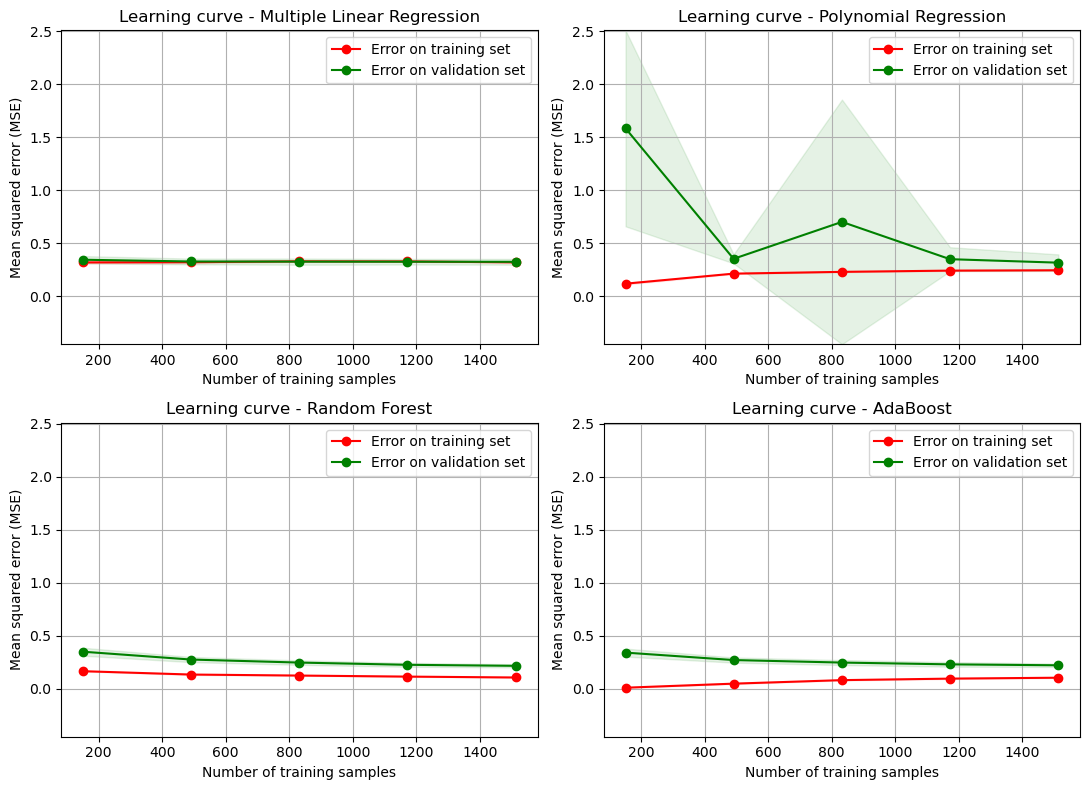

In [205]:
# Plotting
# Function to plot learning curves
def plot_learning_curve(ax, title, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    ax.set_title(title)
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("Mean squared error (MSE)")
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Error on training set")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Error on validation set")
    ax.legend(loc="best")
    ax.set_ylim(y_min, y_max)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# Plot learning curves for each model
plot_learning_curve(axes[0, 0], "Learning curve - Multiple Linear Regression", train_sizes_mr, train_scores_mean_mr, train_scores_std_mr, test_scores_mean_mr, test_scores_std_mr)
plot_learning_curve(axes[0, 1], "Learning curve - Polynomial Regression", train_sizes_poly, train_scores_mean_poly, train_scores_std_poly, test_scores_mean_poly, test_scores_std_poly)
plot_learning_curve(axes[1, 0], "Learning curve - Random Forest", train_sizes_rf, train_scores_mean_rf, train_scores_std_rf, test_scores_mean_rf, test_scores_std_rf)
plot_learning_curve(axes[1, 1], "Learning curve - AdaBoost", train_sizes_ada, train_scores_mean_ada, train_scores_std_ada, test_scores_mean_ada, test_scores_std_ada)

plt.tight_layout()
plt.savefig(plots_path / 'learning_curves.svg')
plt.show()

### **Conclusions:**
#### **Model 1: Multiple Linear Regression**
- **Learning Curve:**
The learning curve plot illustrates changes in errors on the training set (red line) and validation set (green line) with respect to the number of training samples. The training set error remains stable and relatively low, indicating the model’s ability to fit the training data well without overfitting. Initially, the validation set error is higher but decreases over time and stabilizes, approaching the training set error. This trend suggests an improvement in the model’s generalization capability.

- **Prediction vs Actual Data Plot:**
In the scatter plot, most of the model predictions are close to the line of perfect fit (dashed line), indicating accurate predictions by the model. The coefficient of determination R^2 is 0.75, indicating that the model can explain 75% of the variance in the data.

- **Statistical Results:**
The mean squared error (MSE) of the model is 0.321784 for the training set and 0.305350 for the test set, indicating the model’s good generalization ability to new, unseen data. The R^2 values are 0.753924 for the training set and 0.749375 for the test set, suggesting that the model fits well to the training data and performs effectively on the test set.

- **Summary:**
The multiple linear regression model demonstrates robust fitting and good predictive properties. The low MSE and relatively high R^2 values on both datasets indicate the model’s effectiveness in practical applications. The stability of errors and their similar values between the training and validation sets highlight the model’s good generalization, making it useful in various predictive scenarios.

#### **Model 2: Polynomial Regression**
- **Learning Curve:**
The error on the training set remains low, suggesting that the model fits well to the training data without overfitting. On the other hand, the error on the validation set is significantly higher but decreases as more 
data is added, indicating an improvement in the model’s generalization ability. The stabilization of the validation set error (around 1200 samples) at a level close to the training set suggests that the model has good 
generalization properties.

- **Prediction vs Actual Data Plot:**
The scatter plot displays the model predictions compared to the actual data. Most points cluster around the dashed line, indicating that the model is capable of making predictions. The coefficient of determination R^2 
is 0.82, which is higher compared to multiple linear regression.

- **Statistical Results:**
The mean squared error (MSE) is 0.248776 for the training set and 0.222160 for the test set, suggesting that the model performs similarly well on new, unseen data, indicating good generalization ability. 
The R^2 value is 0.809755 for the training set and 0.817655 for the test set, indicating that the model fits well to the training data without significant loss of effectiveness on the test data.

- **Summary:**
The polynomial regression model presented in the analysis demonstrates effective fitting to the data and better predictive capability than multiple linear regression. The low MSE and high R^2 values suggest 
that the model can be effective in practical applications.


#### **Model 3: Random Forest**
- **Learning Curve:**
On the training set, the error is consistently low and decreases as the number of samples increases, indicating the model’s strong ability to fit the data without overfitting. The error on the validation set initially is higher but also systematically decreases, suggesting that the model effectively generalizes to new data. The stabilization of the validation set error at a level close to the training set indicates the model’s excellent generalization ability.

- **Prediction vs Actual Data:**
The concentration of points around the line of perfect fit is noticeably better than previous models.

- **Statistical Results:**
The mean squared error (MSE) for the model is 0.18, which is the best result obtained so far, indicating highly accurate predictions. The R^2 value of 0.85 for both the validation and test sets shows that the model not only fits well to the training data but also maintains this effectiveness on the test data.

- **Summary:**
The Random Forest model presented in this analysis demonstrates the best predictive properties and excellent generalization ability. The low MSE and high R^2 coefficient indicate that the model effectively models the data and can be successfully applied in practical applications. The stability of errors at a low level for both training and validation sets underscores its reliability and effectiveness as a predictive tool.


#### **Model 4: Adaptive Boosting**
- **Learning Curve:**
The error on the training set is low and slightly increases as the number of samples increases, which may indicate slight overfitting with a larger number of data points. However, the error on the validation set initially is higher but decreases over time and stabilizes, indicating an improvement in the model’s ability to generalize.

- **Prediction vs Actual Data:**
On the scatter plot presented, the distribution of AdaBoost model predictions shows proximity to the line representing perfect fit, signaling high accuracy in predictions. The concentration of points around the dashed line emphasizes that the model’s predictions align closely with the actual data values, translating into effective practical application.

- **Statistical Results:**
The mean squared error (MSE) of the model is 0.17, which is low and indicates the model’s effectiveness in precise data modeling. High R^2 values around 0.86 for the validation set demonstrate that the model performs exceptionally well on both training and test data.

- **Summary:**
The AdaBoost model exhibits excellent predictive properties and generalization ability, confirmed by having the lowest MSE among all models and the highest coefficient of determination (R^2). However, the observation of a slight increase in training set error with increasing data points may indicate potential overfitting risk, especially when the model is trained with a very large amount of data. Nevertheless, the stabilization and decrease in validation set error highlight the model’s strong generalization capabilities.


#### **Choosing the best model**:

Analyses of four different regression models — multiple linear regression, polynomial regression, random forest, and AdaBoost — reveal varying levels of effectiveness and specific challenges associated with each. Simpler models like multiple linear and polynomial regression demonstrated robust performance, providing a solid foundation for prediction and generalization. These models are often easier to implement and interpret, which can be advantageous in less complex applications.

On the other hand, more advanced models such as random forest and AdaBoost showed significant improvements in results, especially in accuracy and the ability to model more complex data dependencies. Random forest, with its ensemble technique aggregating multiple models, demonstrated excellent stability and low risk of overfitting, making it exceptionally efficient across a wide range of applications.

AdaBoost, while also achieving exceptionally high R^2 values and low MSE, exhibited a tendency towards minimal overfitting with larger training sample sizes. Despite this slight risk, AdaBoost typically delivers outstanding results, particularly in challenging classification and regression problems where traditional methods may fall short.

Considering these observations, **random forest** emerges as the best model among those analyzed, offering the best balance between accuracy, stability, and overfitting risk. This model is particularly recommended for applications where achieving high accuracy while maintaining model efficiency with diverse and complex data is crucial.
